In [4]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from IPython import get_ipython
# import time
from IPython.display import clear_output

In [5]:
# env = gym.make('CartPole-v1')
# env.reset()
# for _ in range(100):
#     env.render()
#     env.step(env.action_space.sample())
#     # if _%50==0:
#     #     print(_)

# env.close()

In [6]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()

        self.fc1 = nn.Linear(in_features = img_height*img_width*3, out_features = 24)
        self.fc2 = nn.Linear(in_features = 24, out_features = 32)
        self.out = nn.Linear(in_features = 32, out_features = 2)

    def forward(self, t):
        t = t.flatten(start_dim = 1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

In [7]:
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward'))

In [8]:
e = Experience(2,3,1,4)
e

Experience(state=2, action=3, next_state=1, reward=4)

In [9]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count] = experience
        self.push_count = (self.push_count+1)%self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [10]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end)* math.exp(-current_step*self.decay)

In [11]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(device)
        with torch.no_grad():
            return policy_net(state).argmax(dim=1).to(device)

In [12]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make("CartPole-v1").unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False

    def reset(self):
        self.env.reset()
        self.current_screen = None

    def close(self):
        self.env.close()

    def render(self, mode = 'human'):
        return self.env.render(mode)

    def num_actions_available(self):
        return self.env.action_space.n

    def take_action(self, action):
        __, reward, self.done, *_ =  self.env.step(action.item())
        # print(t, '=====', list(t))
        # print(__, '=====', reward, '=====', self.done, '=====', _)
        return torch.tensor([reward], device = self.device)

    def just_starting(self):
        return self.current_screen is None

    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        s1 = self.current_screen
        s2 = self.get_processed_screen()
        self.current_screen = s2
        return s2 - s1

    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]

    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2,0,1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)

    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen

    def transform_screen_data(self, screen):
        screen = np.ascontiguousarray(screen, dtype=np.float32)/255
        screen = torch.from_numpy(screen)
        resize = T.Compose([
            T.ToPILImage(),
            T.Resize((40, 90)),
            T.ToTensor()
        ])
        return resize(screen).unsqueeze(0).to(self.device)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = CartPoleEnvManager(device)
em.reset()
# screen = em.render('rgb_array')

# plt.figure()
# plt.imshow(screen)
# plt.title('Non-processed screen ex')
# plt.show()

/Users/jijnasu/Library/CloudStorage/OneDrive-Personal/Documents/Reinforcement Learning/deeplizard/openaiGym/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jijnasu/Library/CloudStorage/OneDrive-Personal/Documents/Reinforcement Learning/deeplizard/openaiGym/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


/Users/jijnasu/Library/CloudStorage/OneDrive-Personal/Documents/Reinforcement Learning/deeplizard/openaiGym/lib/python3.9/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


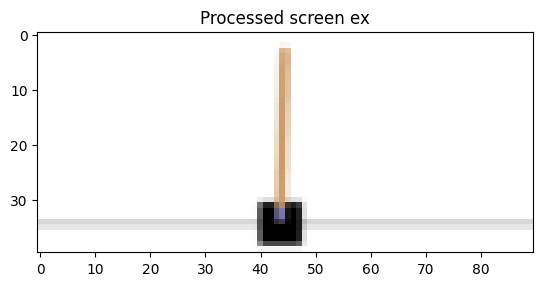

In [14]:
screen = em.get_processed_screen()

plt.figure()
# plt.imshow(screen)
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation='none')
plt.title('Processed screen ex')
plt.show()

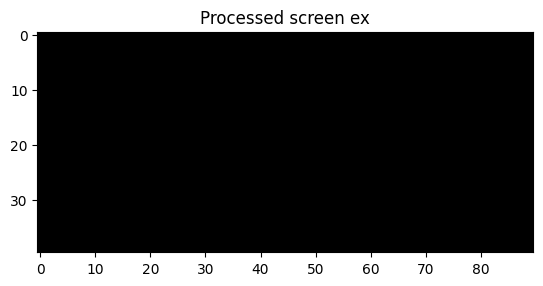

In [15]:
screen = em.get_state()

plt.figure()
# plt.imshow(screen)
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation='none')
plt.title('Processed screen ex')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


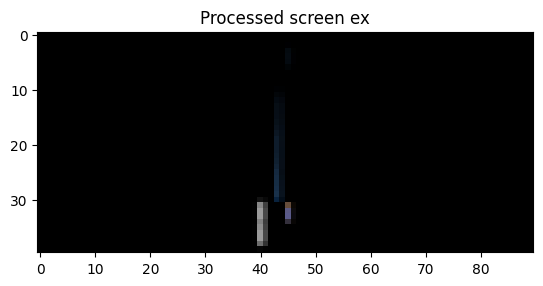

In [16]:
# em = CartPoleEnvManager(device)
# em.reset()
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()
# screen = em.render('rgb_array')

plt.figure()
# plt.imshow(screen)
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation='none')
plt.title('Processed screen ex')
plt.show()

In [17]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print('Episode', len(values), '\n', \
        moving_avg_period, 'episode moving avg: ', moving_avg[-1])
    if get_ipython: clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step = 1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

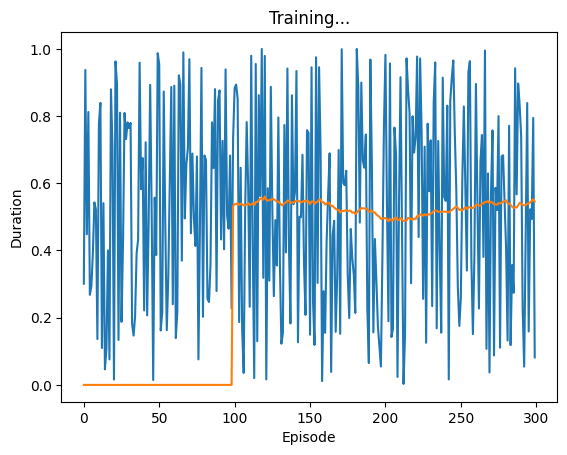

Episode 300 
 100 episode moving avg:  0.5452881


In [18]:
plot(np.random.rand(300), 100)

In [19]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1, t2, t3, t4)

class QValues():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

In [20]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.01
num_episodes = 1000

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)


print((device.type))

cpu


In [22]:
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params = policy_net.parameters(), lr = lr)

In [25]:
episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()

    for timestep in count():
        action = agent.select_action(state, policy_net)
        # print(type(action), action)
        reward = em.take_action(action)
        # reward = em.take_action(torch.tensor([action]))
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations,100)
            break
    if episode%target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

KeyboardInterrupt: 